# Machine Learning Project

- Competition: [Kaggle](https://www.kaggle.com/c/to-loan-or-not-to-loan-that-is-the-question-ac2122/leaderboard)

In [1]:
# configuring pandas
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 40)

In [2]:
# Utilitary functions
from datetime import date

# Format: YYMMDD -> Year is before 2000
def parse_date(d):
    year = int(str(d)[0:2])
    month = int(str(d)[2:4])
    day = int(str(d)[4:6])
    return year, month, day

def calculate_age(year, month, day):
    today = date.today()
    return today.year - year - ((today.month, today.day) < (month, day))

def parse_client_dates(df):
    ages = []
    genders = []
    birthdates = []

    for birth_number in df["birth_number"]:
        year = int(str(birth_number)[0:2])
        month = int(str(birth_number)[2:4])
        day = int(str(birth_number)[4:6])
        # check if the client is female or male
        if month > 12:
            genders.append(1)  # female
            month = month - 50
        else:
            genders.append(0)  # male
        
        year = year + 1900

        ages.append(calculate_age(year, month, day))
        birthdates.append("%s-%s-%s" % (year, month, day))

    # Add the new columns to the dataframe
    df["client_age"] = ages
    df["client_gender"] = genders
    df["birthdate"] = birthdates
    df["birthdate"] = pd.to_datetime(df['birthdate'], format='%Y-%m-%d')

    # Drop the unnecessary column
    df = df.drop(columns="birth_number", axis=1)
    return df

In [3]:
def prep_loans(data_type):
    # process loans data
    df = pd.read_csv("data/loan_" + data_type + ".csv", sep=";", parse_dates=["date"])
    df.rename(columns={'date': 'loan_date','amount':'loan_amount'}, inplace=True)

    return df

In [4]:
from numpy import array
from sklearn.preprocessing import LabelEncoder

def prep_accounts():
    # Add the account data
    df = pd.read_csv("data/account.csv", sep=";", parse_dates=["date"])

    df.rename(columns={"date": "account_date", "district_id": "account_district_id"}, inplace=True)
    
    return df

In [5]:
def prep_dispositions():
     # to join the dispositions table we could count, for each account, the number of disponents
    dispositions_df = pd.read_csv("data/disp.csv", sep=";")
    dispositions_df.rename(columns={"client_id": "disp_client_id", "type": "disp_type"}, inplace=True)

    return dispositions_df

In [6]:
def prep_owners():
    # to join the dispositions table we could count, for each account, the number of disponents
    dispositions_df = pd.read_csv("data/disp.csv", sep=";")
    # disponents = dispositions_df.groupby('account_id')["type"].count().reset_index(name='account_clients')
    # add the owner id
    owners = dispositions_df[dispositions_df.type == "OWNER"][["account_id", "client_id"]].rename(columns={"client_id": "owner_id"})

    return owners

In [7]:
def prep_clients():
    # join clients data
    clients_df = pd.read_csv("data/client.csv", sep=";")
    clients_df = parse_client_dates(clients_df).rename(columns={"client_id": "owner_id", "district_id": "owner_district_id"})

    return clients_df

In [8]:
def prep_demographic(prefix):
    demographic_df = pd.read_csv("data/district.csv", sep=";")
    demographic_df = demographic_df.rename(columns=lambda x: x.strip())    
    demographic_df = demographic_df.rename(columns=lambda x: x.replace("'", ""))   
    
    demographic_df = demographic_df.drop(columns="name", axis=1)

    demographic_df["unemploymant rate 95"] = np.where(demographic_df["unemploymant rate 95"] == '?', demographic_df["unemploymant rate 96"], demographic_df["unemploymant rate 95"])
    demographic_df["no. of commited crimes 95"] = np.where(demographic_df["no. of commited crimes 95"] == '?', demographic_df["no. of commited crimes 96"], demographic_df["no. of commited crimes 95"])

    region_dummies = pd.get_dummies(demographic_df["region"])
    demographic_df = pd.concat([demographic_df, region_dummies], axis=1)
    
    demographic_df = demographic_df.rename(columns={"code": "district_id"})

    return demographic_df.rename(columns=lambda x: prefix + x) 

In [9]:
def prep_transactions(data_type):
    df = pd.read_csv("data/trans_" + data_type + ".csv", sep=";", parse_dates=["date"], low_memory=False)
    
    df.loc[df["operation"].isna(),"operation"] = df.loc[df["operation"].isna(), "k_symbol"]

    df.loc[df["type"] == "withdrawal in cash", "type"] = "withdrawal"
    df.loc[df["type"] == "withdrawal", "amount"] *=-1 

    df = df.drop(['bank', 'account', 'k_symbol'], axis=1)
    
    df.rename(columns={"date": "transaction_date"}, inplace=True)

    return df

In [10]:
def prep_cards(data_type):
    df = pd.read_csv("data/card_" + data_type + ".csv", sep=";", parse_dates=["issued"])

    return df.rename(columns={"type": "card_type", "issued": "card_issued"})

# Data Analysis

- Identify possible outliers on each set

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

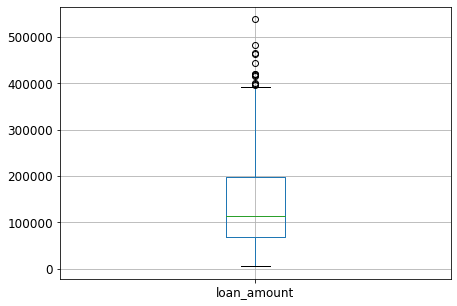

In [12]:
loans_df = prep_loans("train")

loans_df.boxplot(column=['loan_amount'], fontsize=12, figsize=(7, 5))


<AxesSubplot:>

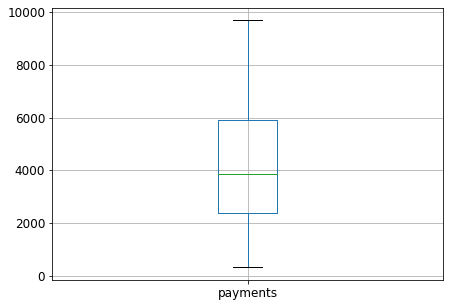

In [13]:
loans_df.boxplot(column=['payments'], fontsize=12, figsize=(7, 5))

<AxesSubplot:xlabel='status', ylabel='count'>

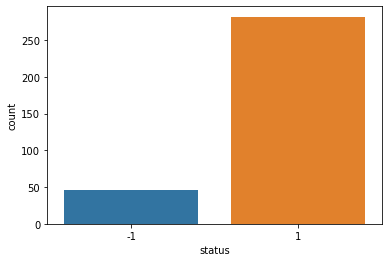

In [14]:
sns.countplot(x="status",data=loans_df)

<AxesSubplot:xlabel='type', ylabel='count'>

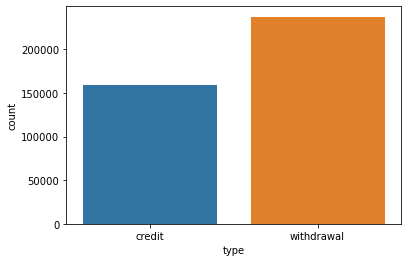

In [15]:
transactions_df = prep_transactions("train")

sns.countplot(x="type",data=transactions_df)

<AxesSubplot:xlabel='amount'>

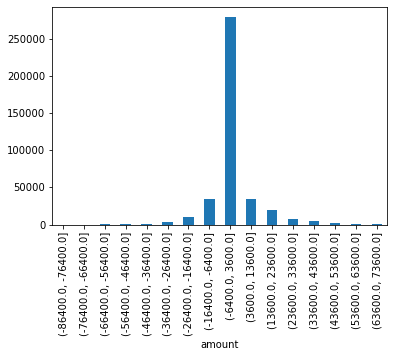

In [16]:
min_amount = transactions_df["amount"].min()
max_amount = transactions_df["amount"].max()

data = transactions_df.groupby(pd.cut(transactions_df["amount"], np.arange(min_amount, max_amount, 10000))).count()[
        "trans_id"]

data.plot.bar()

<AxesSubplot:xlabel='amount'>

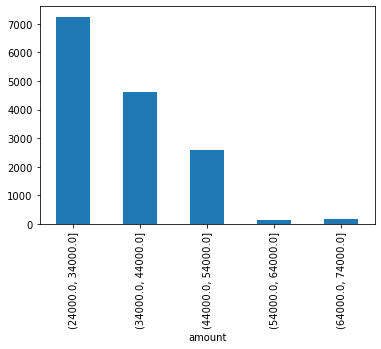

In [17]:
data = transactions_df.groupby(pd.cut(transactions_df["amount"], np.arange(24000, max_amount, 10000))).count()[
        "trans_id"]

data.plot.bar()

<AxesSubplot:xlabel='amount'>

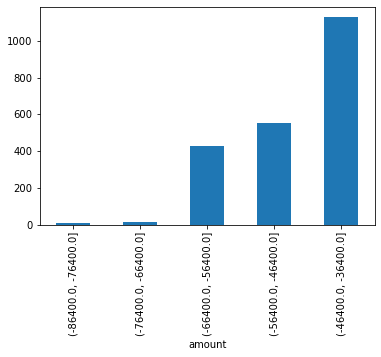

In [18]:
data = transactions_df.groupby(pd.cut(transactions_df["amount"], np.arange(min_amount, -36000, 10000))).count()[
        "trans_id"]

data.plot.bar()

<AxesSubplot:>

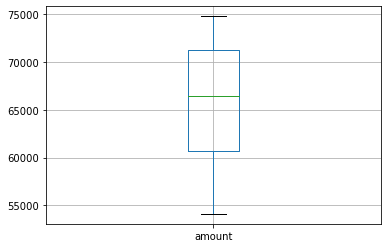

In [19]:
data = transactions_df[transactions_df["amount"] > 54000]

data.boxplot(column=["amount"])

<AxesSubplot:>

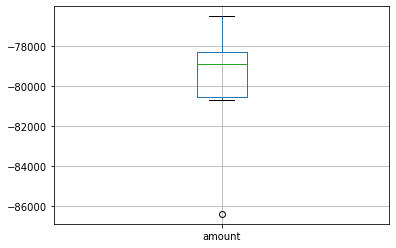

In [20]:
data = transactions_df[transactions_df["amount"] < -76400]

data.boxplot(column=["amount"])

In [21]:
data = transactions_df[transactions_df["amount"] == transactions_df["amount"].min()]

data

,trans_id,account_id,transaction_date,type,operation,amount,balance
303907,855512,2915,1996-06-14,withdrawal,withdrawal in cash,-86400.0,29421.5


We've found one possible outlier, the account with ID 2915 withdrew 86400 credits which is the highest value operation so far for withdrawals. We will take a closer look at this value once we have the bigger picture.

In [22]:
def read_prep_data(data_type):
    # Read and process data
    loans_df = prep_loans(data_type)
    accounts_df = prep_accounts()
    owners_df = prep_owners()
    clients_df = prep_clients()
    transactions_df = prep_transactions(data_type)

    df = pd.merge(loans_df, owners_df, on="account_id")
    df = pd.merge(df, clients_df, on="owner_id")
    df = pd.merge(df, accounts_df, on="account_id")
    df = pd.merge(df, transactions_df, on="account_id")

    return df

In [23]:
# Methods for aggregation
def age_days(x):
    return (x.max()-x.min()).days

def abs_min(x):
    return x.abs().min()
def rangev(x):
    return x.max() - x.min()

def count_out(x):
    return sum(x=="withdrawal")
def count_in(x):
    return sum(x=="credit")

def mean_out(x):
    return np.mean(x=="withdrawal")
def mean_in(x):
    return np.mean(x=="credit")

def cov_out(x):
    return np.cov(x=="withdrawal")
def cov_in(x):
    return np.cov(x=="credit")

def std_in(x):
    return np.std(x=="credit")
def std_out(x):
    return np.std(x=="withdrawal")


def count_classic(x):
    return sum(x == "classic")
def count_junior(x):
    return sum(x == "junior")
def count_gold(x):
    return sum(x == "gold")

In [24]:
# Data Aggregation
def aggregate_transaction_data(df):
    new_columns = ["loan_id", "account_id", "status", "loan_date", 
                "loan_amount", "duration", "payments", 
                "owner_district_id", "client_age",
                "client_gender", "account_district_id", "frequency",
                "account_date", "birthdate"]

    # need to add covariances somehow
    df = df.groupby(new_columns, as_index=False, group_keys=False).agg({
        "transaction_date" : ["max", "min"],
        "operation": ["count"],
        "amount": ["mean","min","max","std","last", np.cov, abs_min, rangev],
        "balance": ["mean","min","max","std","last", np.cov, abs_min, rangev],
        "type": [count_in, count_out, mean_in, mean_out]
    })
    df.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in df.columns]
    
    # retreive some interesting data such as the client's age when the loan was issued

    return df

In [25]:
def aggregate_cards_data(data_type, df):
    df = pd.merge(df, prep_dispositions(), on="account_id", how="left")
    df = pd.merge(df, prep_cards(data_type), on="disp_id", how="left")

    new_columns = [x for x in list(df) if x not in ["card_id", "card_type", "disp_id", "disp_type", "disp_client_id", "card_issued"]]

    df = df.groupby(new_columns, as_index=False, group_keys=False).agg({
        "disp_id": ["count"],
        #"card_type": [count_gold, count_classic, count_junior]
    })
    df.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in df.columns]

    return df

In [26]:
def aggregate_demographic_data(df, prefix):
    demographic_columns = ["district_id", "region", "no. of inhabitants",
                "no. of municipalities with inhabitants < 499",
                "no. of municipalities with inhabitants 500-1999",
                "no. of municipalities with inhabitants 2000-9999",
                "no. of municipalities with inhabitants >10000",
                "no. of cities", "ratio of urban inhabitants",
                "average salary", "unemploymant rate 95", 
                "unemploymant rate 96",
                "no. of enterpreneurs per 1000 inhabitants", 
                "no. of commited crimes 95", "no. of commited crimes 96",
                'Prague', 'central Bohemia', 'east Bohemia', 'north Bohemia', 
                'north Moravia', 'south Bohemia', 'south Moravia', 'west Bohemia']
    
    # for now
    to_ignore = ["region"]

    demographic_df = prep_demographic(prefix)

    return pd.merge(df, demographic_df[["{0}{1}".format(prefix, x) for x in demographic_columns if x not in to_ignore]], on="{0}district_id".format(prefix))
    

## Read Data and Process Aggregations

In [27]:
from dateutil.relativedelta import relativedelta

# Train pipeline
train_df = read_prep_data("train")

In [28]:
train_df = aggregate_transaction_data(train_df)
train_df = aggregate_cards_data("train", train_df)

### Transform Frequency

In [29]:
def process_frequency(df):
    frequency_dummies = pd.get_dummies(df["frequency"])
    df = pd.concat([df, frequency_dummies], axis=1)
    return df.drop(columns=["frequency"], axis=1)

train_df = process_frequency(train_df)

### Process last transactions before loan issue

In [30]:
def process_last_transactions(data_type, df):
    last_transactions = pd.DataFrame()
    
    transactions_df = prep_transactions(data_type)
    
    for index, row in df.iterrows():
        data = transactions_df[transactions_df["account_id"] == row["account_id"]]
        data = data[data["transaction_date"] < row["loan_date"]]
        data = data.sort_values(by=['transaction_date'], ascending=False)
        data = data.iloc[:1]

        data = data.rename(columns=lambda x: "before_loan_" + x)
        data = data.rename(columns={"before_loan_account_id": "account_id"})
        last_transactions = last_transactions.append(data, ignore_index=True)
    last_transactions = last_transactions.drop(["before_loan_trans_id", "before_loan_type", "before_loan_operation"], axis=1)
    
    return pd.merge(df, last_transactions, on="account_id")
    
train_df = process_last_transactions("train", train_df)
    

### Adding relevant features for the problem

<AxesSubplot:>

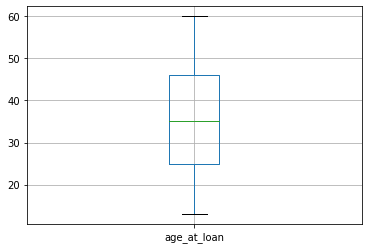

In [31]:
def process_loan_age(df):
    df['age_at_loan'] = df.apply(lambda x: relativedelta(x["loan_date"], x["birthdate"]).years, axis=1)
    return df.drop(["birthdate"], axis=1)

train_df = process_loan_age(train_df)

train_df.boxplot(column=["age_at_loan"])

<AxesSubplot:xlabel='underage', ylabel='count'>

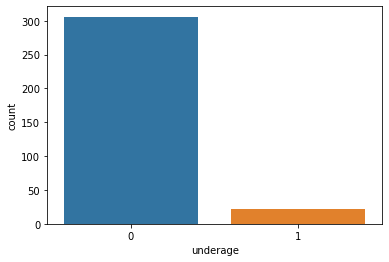

In [32]:
def process_underage_loan(df):
    df["underage"] = df.apply(lambda x: 1 if x["age_at_loan"] < 18 else 0, axis=1)
    return df

train_df = process_underage_loan(train_df)
    
sns.countplot(x="underage",data=train_df)

<AxesSubplot:title={'center':'Account Age at Loan'}, xlabel='account_age_at_loan'>

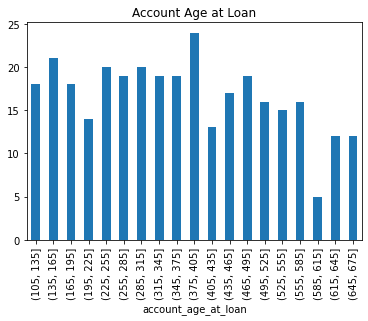

In [33]:
def process_account_age_at_loan(df):
    df['account_age_at_loan'] = df.apply(lambda x:  abs((x["account_date"] - x["loan_date"]).days), axis=1)
    return df

train_df = process_account_age_at_loan(train_df)

min_account_age = train_df["account_age_at_loan"].min()
max_account_age = train_df["account_age_at_loan"].max()

    
data = train_df.groupby(pd.cut(train_df["account_age_at_loan"], np.arange(min_account_age, max_account_age, 30))).count()[
        "loan_id"]

data.plot.bar(title="Account Age at Loan")

## Transaction Dates May be important!

- Days from first transaction till loan
- Days from last transaction till loan

We can infer there are no transactions after the loan issuance

<AxesSubplot:xlabel='days_from_first_trans_till_loan'>

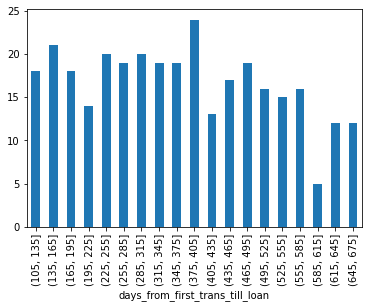

In [34]:
def process_days_from_first_transaction_till_loan(df):
    df['days_from_first_trans_till_loan'] = df.apply(lambda x:  abs((x["transaction_date_min"] - x["loan_date"]).days), axis=1)
    return df

train_df = process_days_from_first_transaction_till_loan(train_df)

_min = train_df["days_from_first_trans_till_loan"].min()
_max = train_df["days_from_first_trans_till_loan"].max()
    
data = train_df.groupby(pd.cut(train_df["days_from_first_trans_till_loan"], np.arange(_min, _max, 30))).count()[
        "loan_id"]

data.plot.bar()

<AxesSubplot:xlabel='days_from_last_trans_till_loan'>

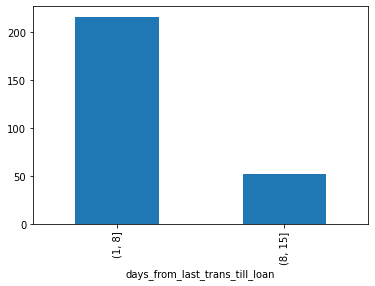

In [35]:
def process_days_from_last_transaction_till_loan(df):
    df['days_from_last_trans_till_loan'] = df.apply(lambda x: abs((x["transaction_date_max"] - x["loan_date"]).days), axis=1)
    return df

train_df = process_days_from_last_transaction_till_loan(train_df)

_min = train_df["days_from_last_trans_till_loan"].min()
_max = train_df["days_from_last_trans_till_loan"].max()
    
data = train_df.groupby(pd.cut(train_df["days_from_last_trans_till_loan"], np.arange(_min, _max, 7))).count()[
        "loan_id"]

data.plot.bar()

In [36]:
def normalize_dates(df):
    # Transform this to blocks of 1 month
    df['days_from_first_trans_till_loan'] = df.apply(lambda x: int(x["days_from_first_trans_till_loan"]/30), axis=1)
    # 1 month blocks
    df['account_age_at_loan'] = df.apply(lambda x: int(x["account_age_at_loan"]/30), axis=1)
    
    df = df.rename(columns={"days_from_first_trans_till_loan": "months_from_first_trans_to_loan",
                           "account_age_at_loan": "account_months_at_loan"})
    
    # drop useless features
    df = df.drop(columns=["account_date", "transaction_date_max", "transaction_date_min", "before_loan_transaction_date"], axis=1)
    
    # we can then transform the loan date in years
    df["loan_date"] = df.apply(lambda x: x["loan_date"].year, axis=1)
    
    return df

train_df = normalize_dates(train_df)

### Wrap-Up data and Sort by Loan Data

In [37]:
train_df.loc[train_df["status"] == 1, "status"] = 0
train_df.loc[train_df["status"] == -1, "status"] = 1

train_df = aggregate_demographic_data(train_df, "owner_")

<AxesSubplot:>

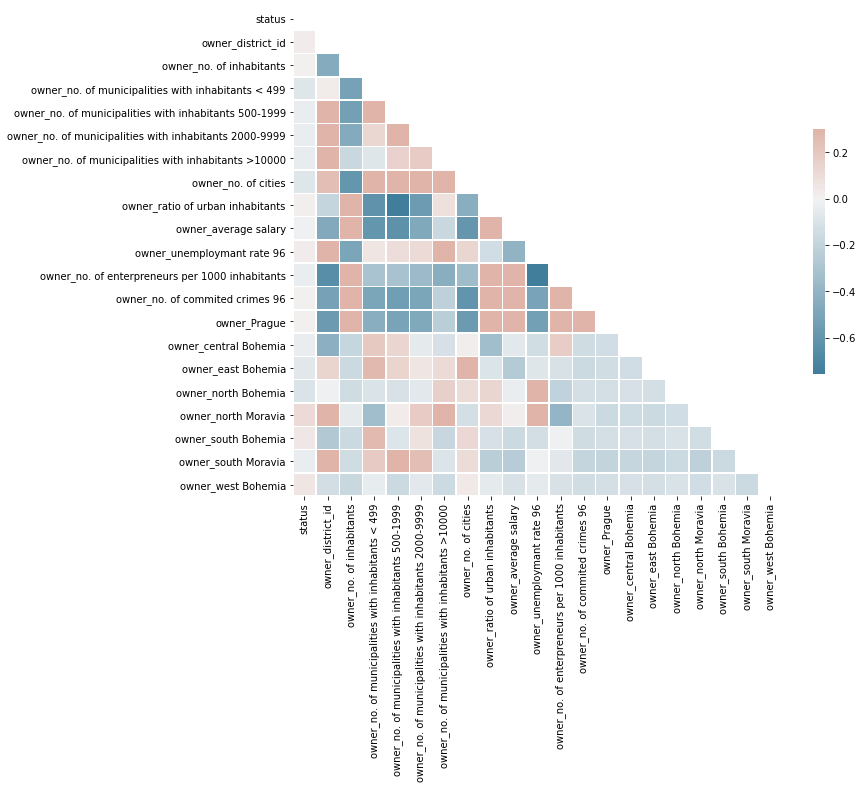

In [38]:
to_analyse = ['status', 'owner_district_id', 
              'owner_no. of inhabitants', 'owner_no. of municipalities with inhabitants < 499', 
              'owner_no. of municipalities with inhabitants 500-1999', 
              'owner_no. of municipalities with inhabitants 2000-9999', 
              'owner_no. of municipalities with inhabitants >10000', 
              'owner_no. of cities', 'owner_ratio of urban inhabitants', 'owner_average salary', 
              'owner_unemploymant rate 95', 'owner_unemploymant rate 96', 
              'owner_no. of enterpreneurs per 1000 inhabitants', 'owner_no. of commited crimes 95', 
              'owner_no. of commited crimes 96', 'owner_Prague', 'owner_central Bohemia', 'owner_east Bohemia', 
              'owner_north Bohemia', 'owner_north Moravia', 'owner_south Bohemia', 'owner_south Moravia', 
              'owner_west Bohemia']

demographic_df = train_df[to_analyse]

# sns.set_theme(style="white")

corr = demographic_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We've opted to remove everything from demographic data and leave the regions, the number of entrepeneurs, district_id and salary.

In [39]:
def remove_demographic(df, prefix):
    columns=['no. of inhabitants', 'no. of municipalities with inhabitants < 499', 
            'no. of municipalities with inhabitants 500-1999', 
            'no. of municipalities with inhabitants 2000-9999', 
            'no. of municipalities with inhabitants >10000', 
            'no. of cities', 
            'ratio of urban inhabitants', 
            'unemploymant rate 95', 
            'unemploymant rate 96', 
            'no. of commited crimes 95', 
            'no. of commited crimes 96']
    
    columns = ["{0}{1}".format(prefix, x) for x in columns]
    
    return df.drop(columns = columns, axis=1)

train_df = remove_demographic(train_df, "owner_")

In [40]:
# we should sort by loan data to have a realistic train/test split while training
train_df.sort_values(by=['loan_date'], inplace=True)
train_df = train_df.reset_index(drop=True)

train_df.to_csv("train.csv", index=False)


train_93_95_df = train_df[train_df["loan_date"] < 1996]
train_96_df = train_df[train_df["loan_date"] == 1996]

train_93_95_df.to_csv("train_93_95.csv", index=False)
train_96_df.to_csv("train_96.csv", index=False)


print("Train data")
train_df

Train data


,loan_id,account_id,status,loan_date,loan_amount,duration,payments,owner_district_id,client_age,client_gender,account_district_id,operation_count,amount_mean,amount_min,amount_max,amount_std,amount_last,amount_cov,amount_abs_min,amount_rangev,balance_mean,balance_min,balance_max,balance_std,balance_last,balance_cov,balance_abs_min,balance_rangev,type_count_in,type_count_out,type_mean_in,type_mean_out,disp_id_count,issuance after transaction,monthly issuance,weekly issuance,before_loan_amount,before_loan_balance,age_at_loan,underage,account_months_at_loan,months_from_first_trans_to_loan,days_from_last_trans_till_loan,owner_average salary,owner_no. of enterpreneurs per 1000 inhabitants,owner_Prague,owner_central Bohemia,owner_east Bohemia,owner_north Bohemia,owner_north Moravia,owner_south Bohemia,owner_south Moravia,owner_west Bohemia
0,5314,1787,1,1993,96396,12,8033,30,74,1,30,4,5025.000000,1100.0,9900.0,3774.806838,3300.0,1.424917e+07,1100.0,8800.0,12250.000000,1100.0,20100.0,8330.866301,20100.0,6.940333e+07,1100.0,19000.0,4,0,1.000000,0.000000,1,0,0,1,3300.0,20100.0,45,0,3,3,15,9650,100,0,0,0,0,0,0,0,1
1,6820,9034,0,1993,38148,12,3179,1,56,1,1,29,1645.720690,-20600.0,32706.0,12844.874772,-9115.0,1.649908e+08,9.9,53306.0,37462.093103,900.0,62324.6,13293.431805,47725.8,1.767153e+08,900.0,61424.6,18,11,0.620690,0.379310,1,0,1,0,-9115.0,47725.8,28,0,5,5,2,12541,167,1,0,0,0,0,0,0,0
2,6228,6034,1,1993,464520,60,7742,77,81,1,6,68,1284.857353,-41000.0,47757.0,18515.433732,290.7,3.428213e+08,30.0,88757.0,51760.016176,200.0,125943.1,27848.686708,101797.3,7.755494e+08,200.0,125743.1,31,37,0.455882,0.544118,1,0,0,1,290.7,101797.3,52,0,8,8,1,8909,113,0,0,0,0,1,0,0,0
3,6111,5428,1,1993,174744,24,7281,24,73,1,24,32,1816.900000,-52600.0,47436.0,18855.750711,40175.0,3.555393e+08,14.6,100036.0,37485.456250,1000.0,105628.0,28302.653143,58140.9,8.010402e+08,1000.0,104628.0,16,16,0.500000,0.500000,1,0,1,0,40175.0,58140.9,45,0,5,5,3,8991,128,0,0,0,0,0,0,0,1
4,7097,10266,1,1993,75624,24,3151,54,62,0,54,23,1824.130435,-31100.0,49887.0,21502.123351,-13500.0,4.623413e+08,50.5,80987.0,50009.908696,400.0,89754.8,20688.418049,41954.8,4.280106e+08,400.0,89354.8,15,8,0.652174,0.347826,1,0,1,0,-13500.0,41954.8,35,0,6,6,6,9897,140,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6354,6688,0,1996,22968,36,638,16,71,1,16,11,3530.090909,-3600.0,8200.0,4586.053446,8155.0,2.103189e+07,16.3,11800.0,23324.936364,1000.0,38831.0,11195.573958,38831.0,1.253409e+08,1000.0,37831.0,10,1,0.909091,0.090909,1,0,1,0,8155.0,38831.0,46,0,4,4,11,8427,107,0,0,0,0,0,1,0,0
324,6805,8972,0,1996,45024,48,938,70,64,1,70,39,984.215385,-22100.0,31636.5,12758.414420,-17800.0,1.627771e+08,14.6,53736.5,41994.907692,800.0,63659.3,13151.510254,38384.3,1.729622e+08,800.0,62859.3,20,19,0.512821,0.487179,1,0,1,0,-17800.0,38384.3,39,0,7,7,4,10177,81,0,0,0,0,1,0,0,0
325,6816,9017,1,1996,100224,48,2088,70,64,1,70,18,1743.727778,-15100.0,18792.0,8029.859466,-15100.0,6.447864e+07,26.5,33892.0,28124.933333,700.0,46487.1,9838.648370,31387.1,9.679900e+07,700.0,45787.1,15,3,0.833333,0.166667,1,0,1,0,-15100.0,31387.1,39,0,4,4,5,10177,81,0,0,0,0,1,0,0,0
326,7194,10762,0,1996,68832,36,1912,1,62,0,1,53,972.467925,-24000.0,28353.0,11799.703118,-1500.0,1.392330e+08,14.6,52353.0,37557.054717,700.0,61939.6,12288.790411,51540.7,1.510144e+08,700.0,61239.6,24,29,0.452830,0.547170,1,0,1,0,-1500.0,51540.7,37,0,11,11,5,12541,167,1,0,0,0,0,0,0,0


Looking for the Account ID 2915, there was no matching record, so the possible outlier on the transactions dataframe is irrelevant since the data is aggregated.

In [41]:
# Test Pipeline
test_df = read_prep_data("test")

test_df.status = test_df.status.fillna('')
test_df = aggregate_transaction_data(test_df)
test_df = aggregate_cards_data("test", test_df)
test_df = process_frequency(test_df)
test_df = process_last_transactions("test", test_df)
test_df = process_loan_age(test_df)
test_df = process_underage_loan(test_df)
test_df = process_account_age_at_loan(test_df)
test_df = aggregate_demographic_data(test_df, "owner_")
test_df = remove_demographic(test_df, "owner_")

test_df = process_days_from_first_transaction_till_loan(test_df)
test_df = process_days_from_last_transaction_till_loan(test_df)
test_df = normalize_dates(test_df)

test_df.to_csv("test.csv", index=False)

print("Test Data")
test_df


Test Data


,loan_id,account_id,status,loan_date,loan_amount,duration,payments,owner_district_id,client_age,client_gender,account_district_id,operation_count,amount_mean,amount_min,amount_max,amount_std,amount_last,amount_cov,amount_abs_min,amount_rangev,balance_mean,balance_min,balance_max,balance_std,balance_last,balance_cov,balance_abs_min,balance_rangev,type_count_in,type_count_out,type_mean_in,type_mean_out,disp_id_count,issuance after transaction,monthly issuance,weekly issuance,before_loan_amount,before_loan_balance,age_at_loan,underage,account_months_at_loan,owner_average salary,owner_no. of enterpreneurs per 1000 inhabitants,owner_Prague,owner_central Bohemia,owner_east Bohemia,owner_north Bohemia,owner_north Moravia,owner_south Bohemia,owner_south Moravia,owner_west Bohemia,months_from_first_trans_to_loan,days_from_last_trans_till_loan
0,4962,25,,1997,30276,12,2523,68,59,0,68,164,192.816463,-62900.0,49734.0,19772.510052,-1110.0,3.909522e+08,14.6,112634.0,62991.264634,900.0,119652.7,22476.347980,31621.9,5.051862e+08,900.0,118752.7,51,113,0.310976,0.689024,1,0,1,0,-1110.0,31621.9,35,0,16,9893,96,0,0,0,0,1,0,0,0,16,2
1,5051,378,,1997,230400,60,3840,68,60,0,68,168,293.317262,-59900.0,48038.0,20263.281371,-4.0,4.106006e+08,2.0,107938.0,79500.538095,20574.0,145352.1,22324.051660,49277.3,4.983633e+08,20574.0,124778.1,53,115,0.315476,0.684524,1,0,1,0,-4.0,49277.3,36,0,14,9893,96,0,0,0,0,1,0,0,0,14,4
2,5207,1244,,1997,35904,48,748,68,75,0,68,59,299.361017,-7200.0,7842.0,3026.826901,-600.0,9.161681e+06,14.6,15042.0,22981.055932,900.0,34278.5,6022.073346,17662.3,3.626537e+07,900.0,33378.5,24,35,0.406780,0.593220,1,0,1,0,-600.0,17662.3,51,0,9,9893,96,0,0,0,0,1,0,0,0,9,9
3,5561,2910,,1998,437460,60,7291,68,68,1,68,53,641.798113,-44500.0,65622.0,26560.241912,-1800.0,7.054465e+08,14.6,110122.0,48935.435849,900.0,101929.2,24396.939772,34015.2,5.952107e+08,900.0,101029.2,20,33,0.377358,0.622642,1,0,1,0,-1800.0,34015.2,45,0,10,9893,96,0,0,0,0,1,0,0,0,10,9
4,5906,4533,,1998,81144,36,2254,68,77,1,68,51,1290.200000,-62500.0,48449.0,25868.104611,290.1,6.691588e+08,14.6,110949.0,67815.174510,200.0,127543.0,26169.159053,90314.9,6.848249e+08,200.0,127343.0,26,25,0.509804,0.490196,1,0,1,0,290.1,90314.9,53,0,9,9893,96,0,0,0,0,1,0,0,0,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,7242,11027,,1997,48096,24,2004,32,63,0,32,83,389.793976,-20320.0,18038.0,7409.235174,-2300.0,5.489677e+07,19.0,38358.0,33044.015663,800.0,51009.5,8252.713497,32352.9,6.810728e+07,800.0,50209.5,35,48,0.421687,0.578313,1,0,0,1,-2300.0,32352.9,39,0,15,9272,118,0,0,0,1,0,0,0,0,15,2
350,7067,10134,,1998,136368,24,5682,22,52,0,22,59,879.644068,-46800.0,48627.0,20916.771724,-8400.0,4.375113e+08,14.6,95427.0,60593.840678,600.0,119446.2,21974.288190,51899.0,4.828693e+08,600.0,118846.2,25,34,0.423729,0.576271,1,0,1,0,-8400.0,51899.0,28,0,8,8620,100,0,0,0,0,0,0,0,1,8,1
351,7122,10365,,1997,260640,36,7240,22,72,1,22,78,148.276923,-30000.0,41871.0,12549.498909,12284.0,1.574899e+08,4.6,71871.0,31518.182051,-718.6,88731.8,20629.925861,11565.4,4.255938e+08,699.3,89450.4,29,49,0.371795,0.628205,1,0,1,0,12284.0,11565.4,47,0,16,8620,100,0,0,0,0,0,0,0,1,16,3
352,7221,10915,,1998,152460,60,2541,25,70,1,25,118,81.709322,-15200.0,22868.0,7010.892528,-3651.0,4.915261e+07,30.0,38068.0,20874.116102,600.0,52438.0,9790.925694,9641.6,9.586223e+07,600.0,51838.0,36,82,0.305085,0.694915,1,0,0,1,-3651.0,9641.6,46,0,16,8554,113,0,0,0,0,0,0,0,1,16,3
